<center><h1> Relaxation time analysis from MD simulations </h1> </center>

In [1]:
"""Jupyter Notebook for relaxation time analysis"""
#The main analysis parts adapted from script by  H. Antila, with help from S. Ollila and T. Ferreira
#saved in relaxation_times.py
# Last modified by R. Nencini, 19.10.2021

import sys
import numpy as np
from scipy import optimize
import relaxation_times as rt
import matplotlib.pyplot as plt
import os
import re
#from numba import jit #

#gyromagnetic ratios for further developmant
# !!! NOTICE!!!
#values taken from matlab code and projecct work and slightly different than those in Wikipedia
#these values are also in the external file --> if change is needed; has to be changed there
#values here in jupyter just for the information and verify, why they are different
#!!! NOTICE END !!!
gammaD=41.695*10**6; #r*s^(-1)*T^(-1)
gammaH=267.513*10**6;
gammaC=67.262*10**6;
gammaN=-27.166*10**6;

<h3> 1) Create README.yaml file </h3>

Code exists and will be soon implemented for this particular case <br>
a special attention is put on extra xtc file that is used for correlation function calculation

<h3> 2) Calculate correlation functions </h3>
Code exists and will be soon implemented <br> 
Includes creation of ndx file and calling gromacs for corellation function analysis

<h3> 3) Get spin relaxation data and time scales of dynamics </h3>



<h4> 3.1) Set analysis parameters</h4>

In [2]:
"""Parameters to be specified by the user"""
OP=0 # order parameter
smallest_corr_time=0 # enter in log scale -3 fs; 0 ps; 3 ns; 6 us;
biggest_corr_time=5 # same as above
N_exp_to_fit=100 # number of exponential functions to be fitted between the samlles and biggest corr time
analyze=1/50 # the proportin of correlation data to be used for fitting, ex. 1/2 uses first half of the data
#magnetic_field=2.35 # 5.99 # 8.49 T (values used in SDS paper, J.Chem. Soc.,, Faraday Trans. 1, 1988, 84(12), 4475-4486)
magn_field_MHz=850 # for values in MHz
magnetic_field=magn_field_MHz*2*np.pi/gammaH*10**6
nuclei="15N" #nuclei to calculate: 2H-deutherium; 13C - carbon; 15N - nitrogen 

<h4>3.2) Set paths and names</h4>

In [3]:

folder_path="/home/nenciric/Documents/git/CorysPeptides/figure_time_scales_protein/93_hMff_50SDS_micelle_310K_CHARMM_lastframe_FromSofia_SDS_Protein_SOD_solvated_OPC_local_run_20ps_mahti_370ns_mahti_360ns_mahti_2940ns_no_solvent/"
output_path="/home/nenciric/Documents/git/NMR_FF_tools/relaxation_times/testing_output/"
output_name="hMff_50SDS"
#output_name=output_path+output_name
author_name="Ricky Nencini"

<h4>3.3) Perform the calculations </h4>

In [ ]:
"""Analyze individual correlation function - in case of lipids etc..."""
#input_corr_file="alphaCF.xvg"
#AA=rt.GetRelaxationData(OP,smallest_corr_time, biggest_corr_time, N_exp_to_fit,analyze,magnetic_field,input_corr_file,nuclei,output_name)

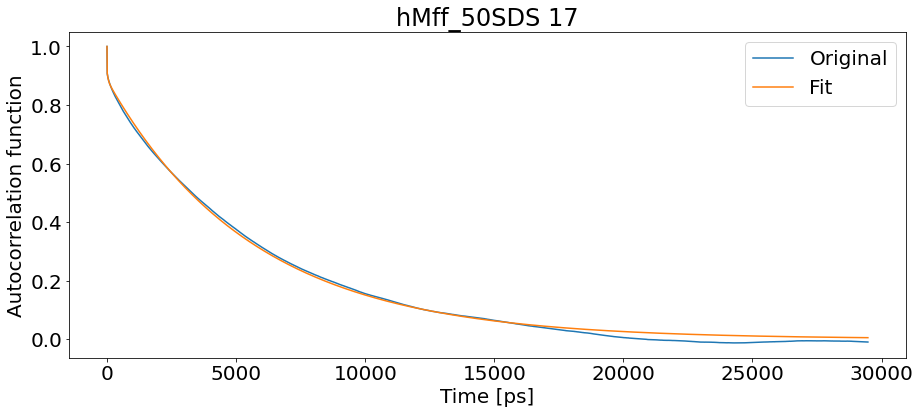

T1: 0.7585409443654909 T2: 0.10468102246976246 NOE: 0.8206569231645211


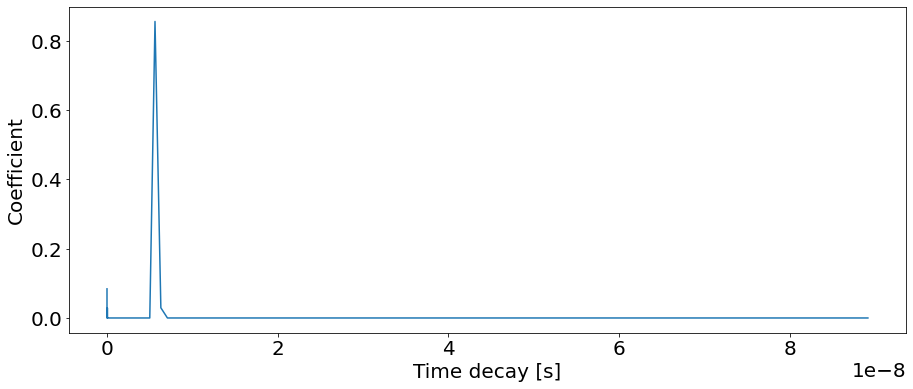

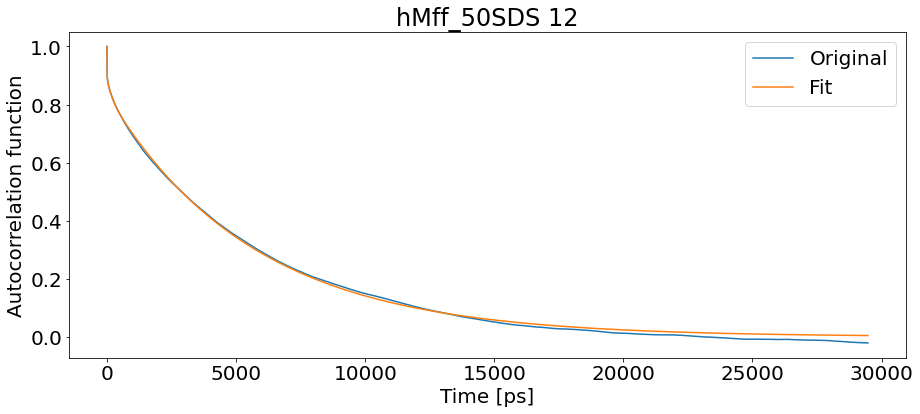

T1: 0.7758895075398136 T2: 0.1108818060996737 NOE: 0.719228570679233


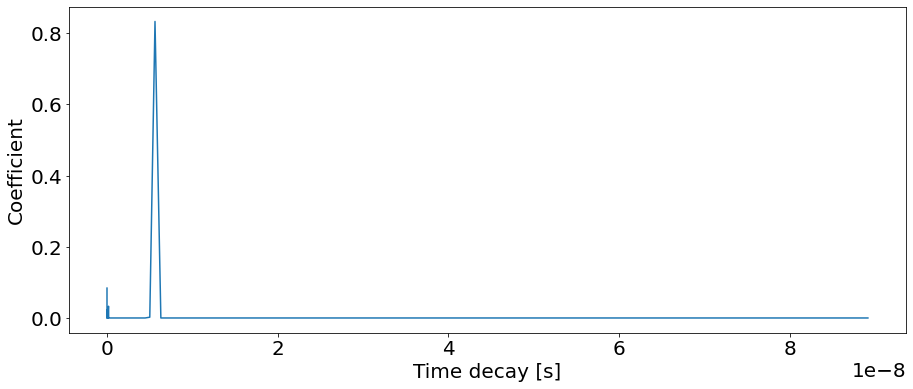

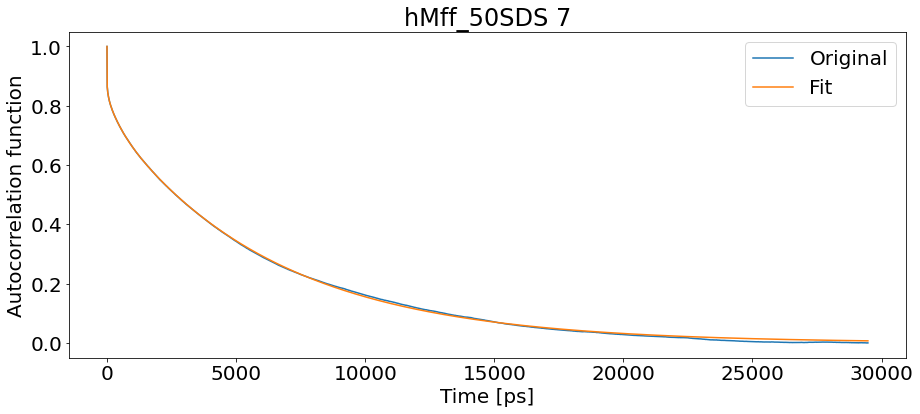

T1: 0.8703989381148792 T2: 0.10890468355686639 NOE: 0.6836083086363773


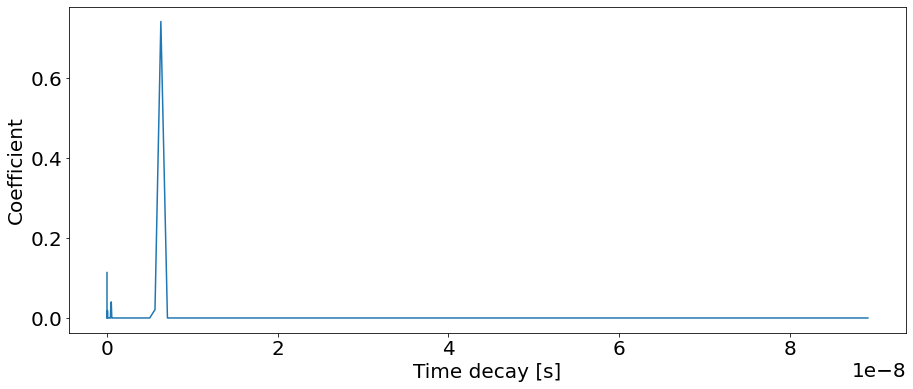

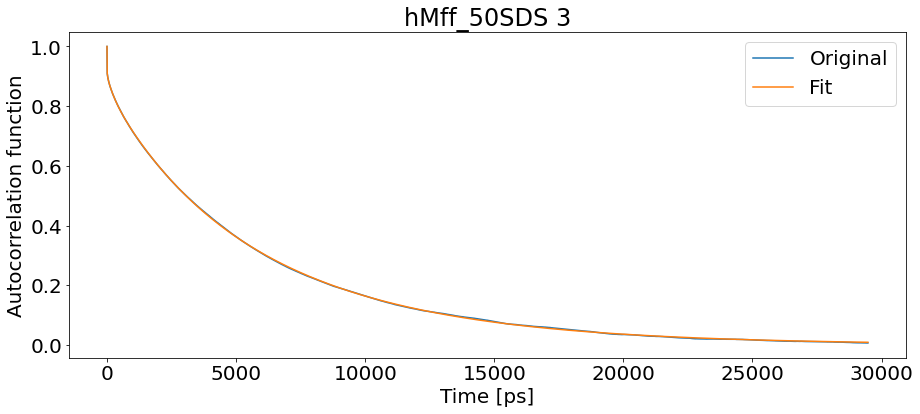

T1: 0.7723943685923849 T2: 0.1013545543659318 NOE: 0.7322652674965999


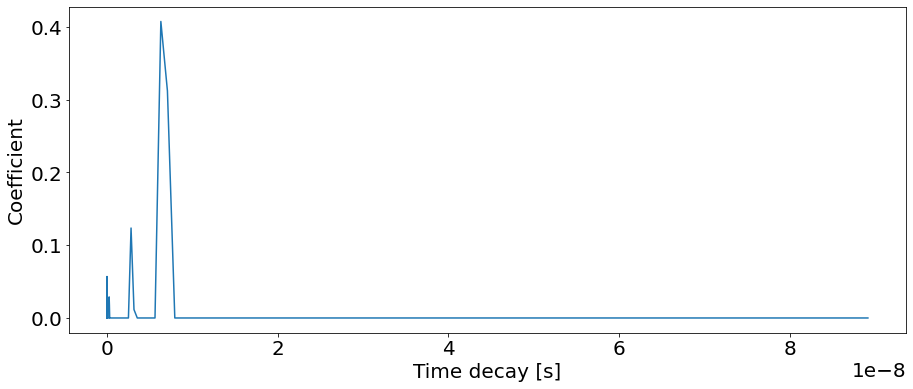

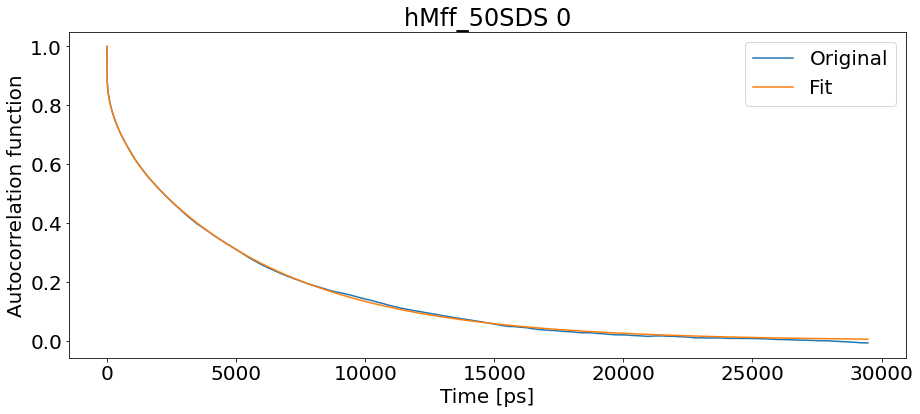

T1: 0.8120702786742685 T2: 0.11973236956116043 NOE: 0.6265166322511684


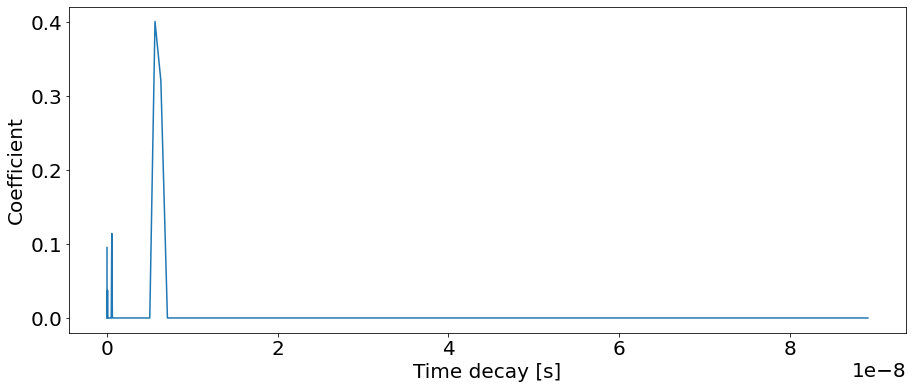

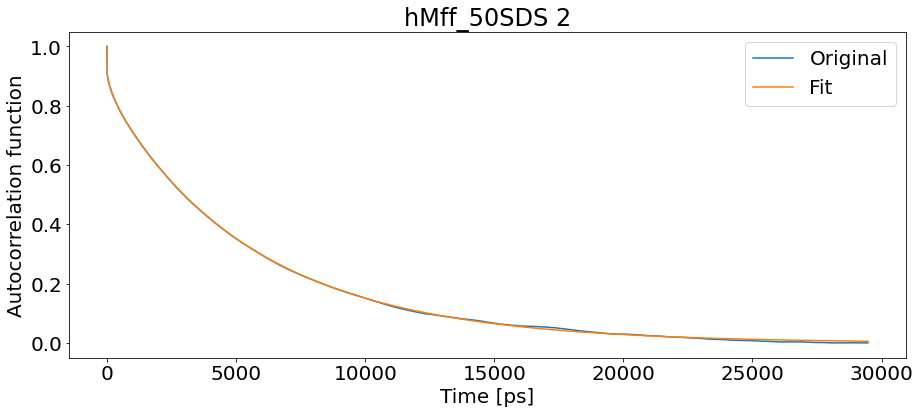

T1: 0.7639488006707068 T2: 0.10647838462580742 NOE: 0.734283594819297


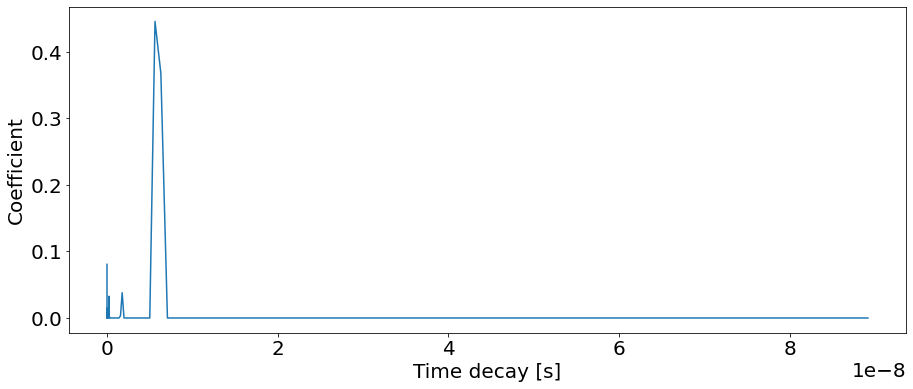

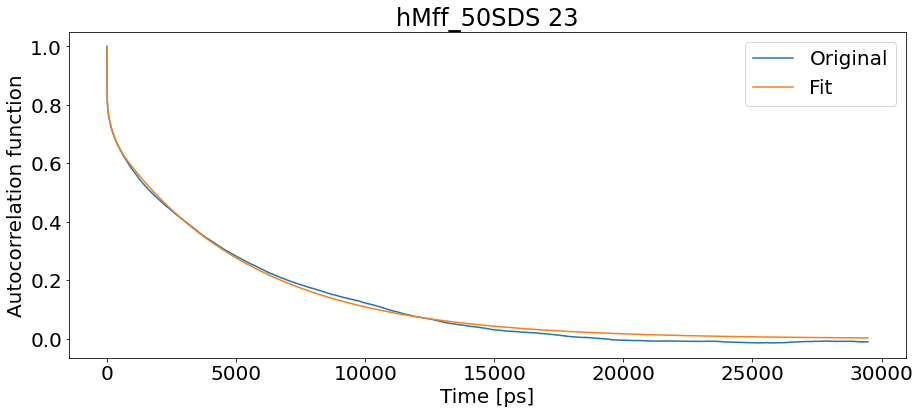

T1: 0.8488326895825955 T2: 0.1358853487767228 NOE: 0.6018606314553204


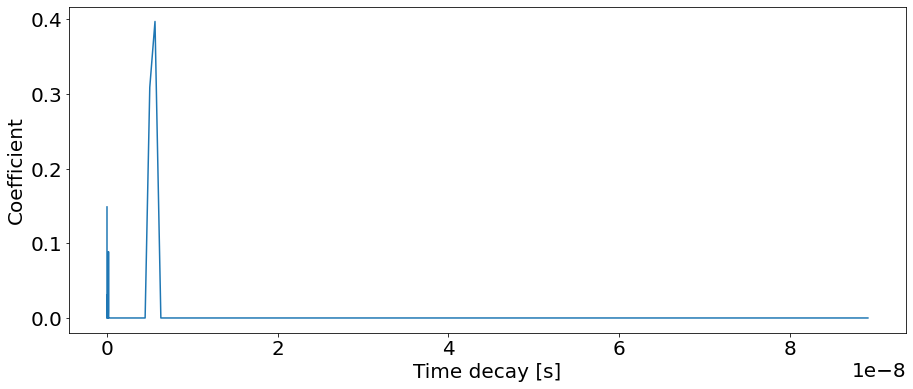

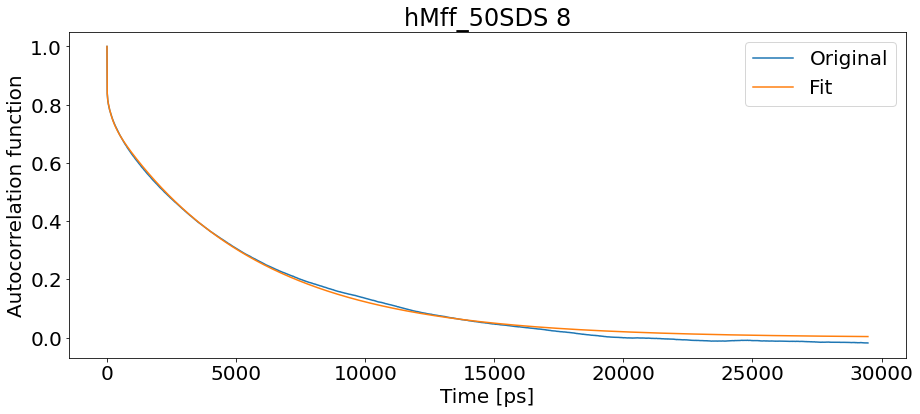

T1: 0.8270906588584864 T2: 0.1243776867703492 NOE: 0.6698114460671138


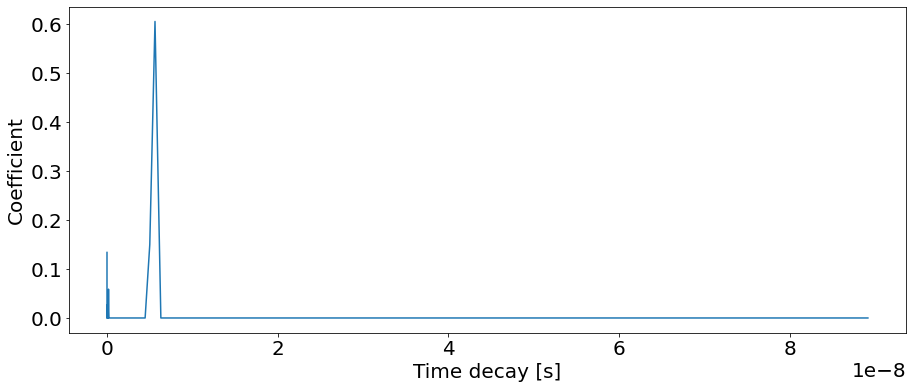

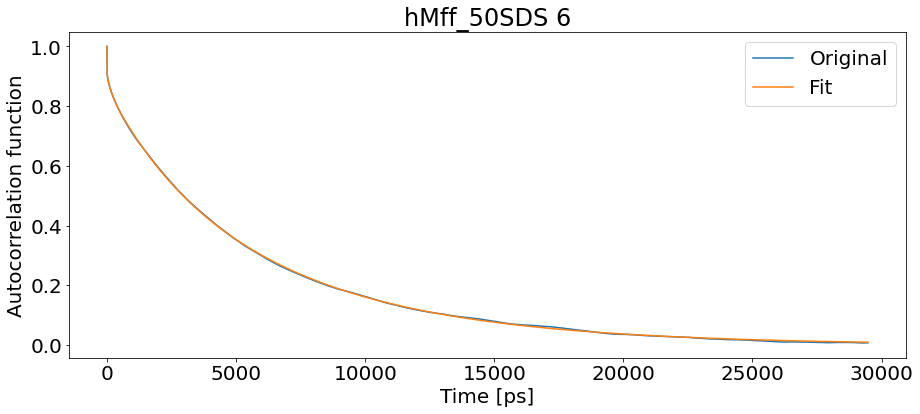

T1: 0.7564615922068437 T2: 0.10209104190120746 NOE: 0.7376694673375923


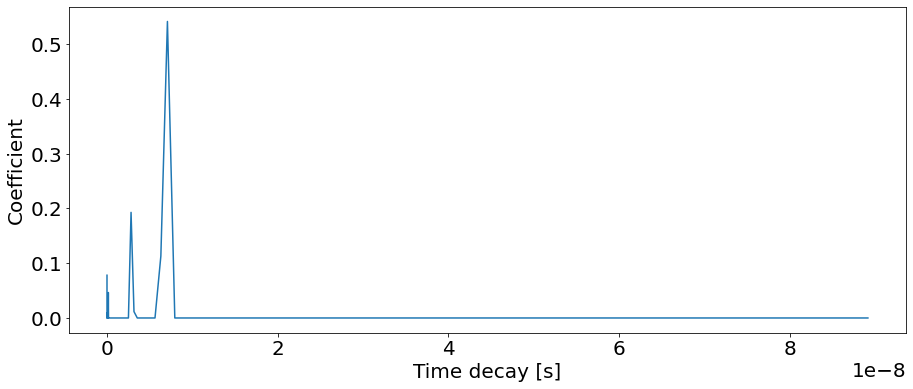

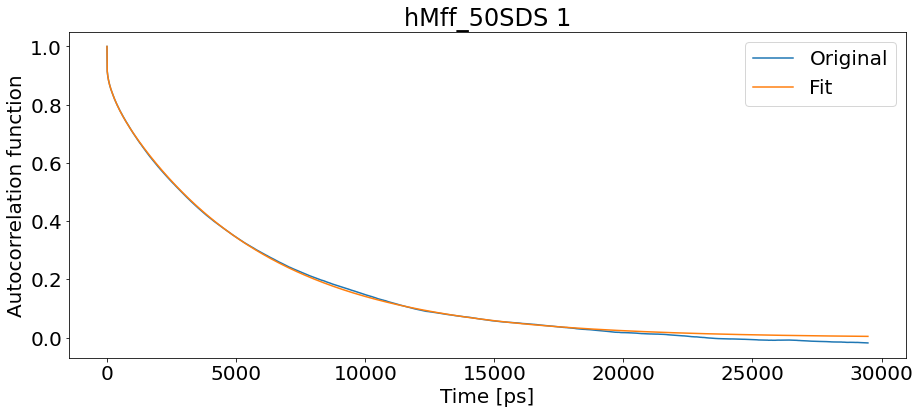

T1: 0.7569194865640743 T2: 0.10998588927032678 NOE: 0.7115841041214503


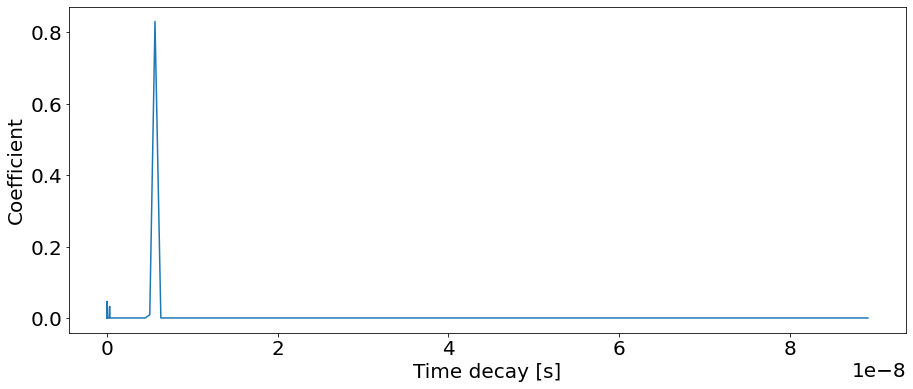

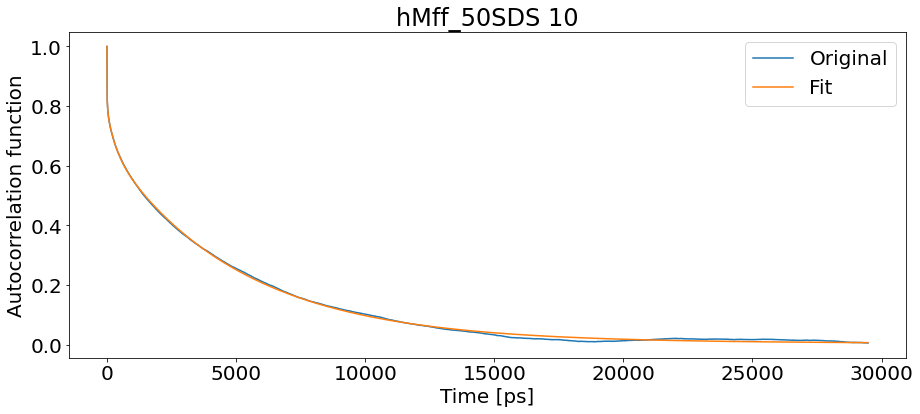

T1: 0.8219927970422003 T2: 0.1283886213353126 NOE: 0.5594421813343411


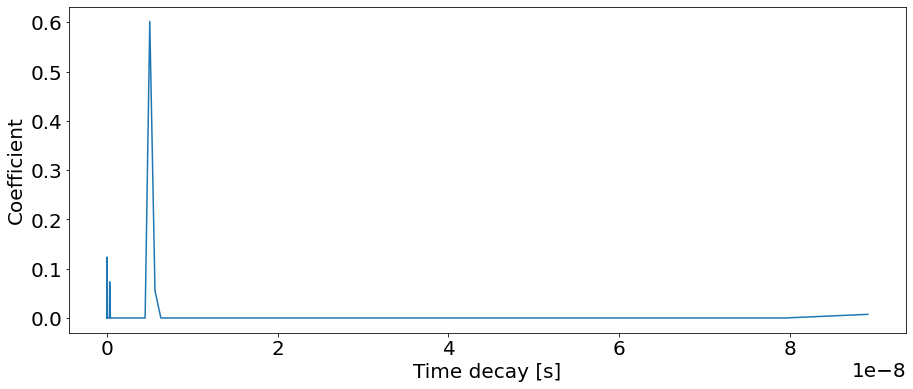

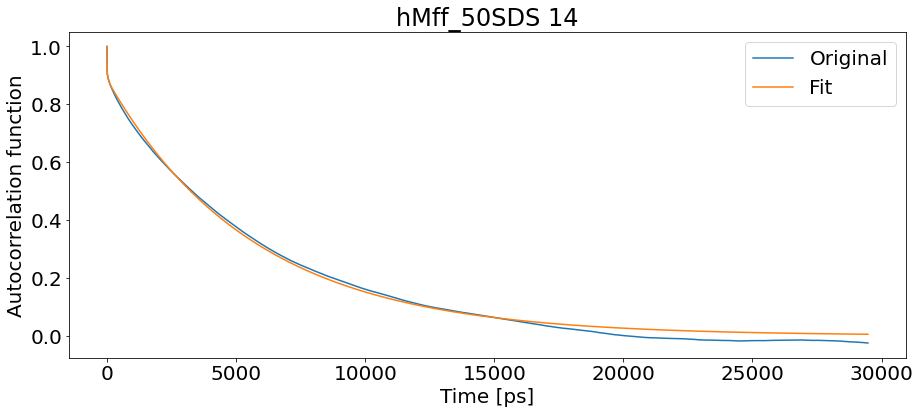

T1: 0.7592096438094433 T2: 0.10449750613909635 NOE: 0.8221877658514768


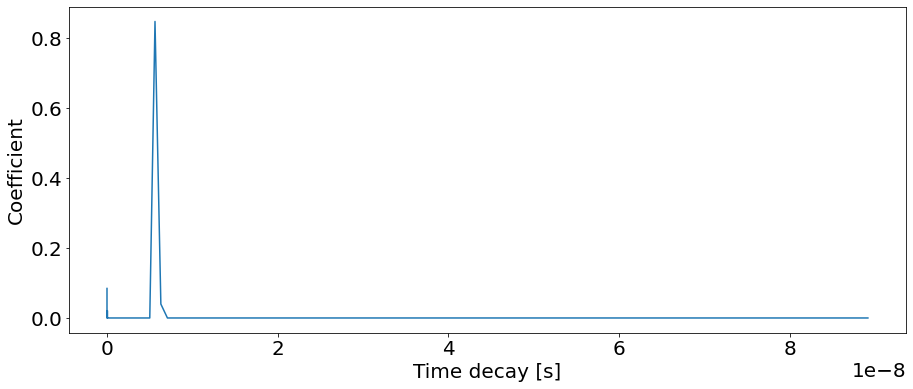

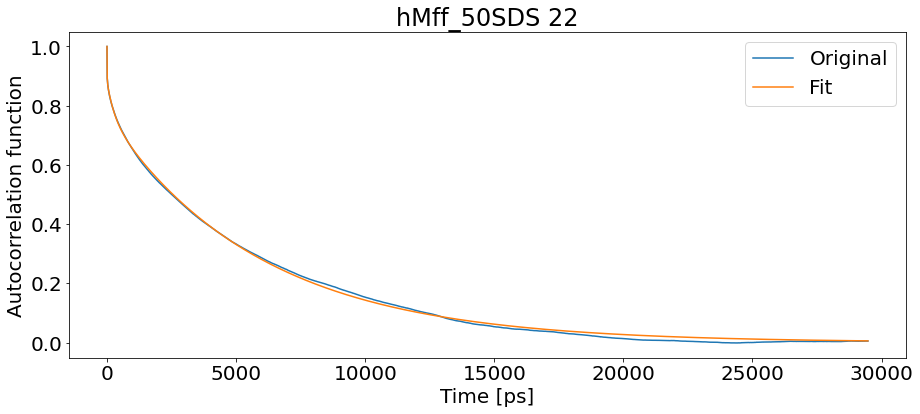

T1: 0.8195601518789926 T2: 0.11334454761424197 NOE: 0.5948582991833984


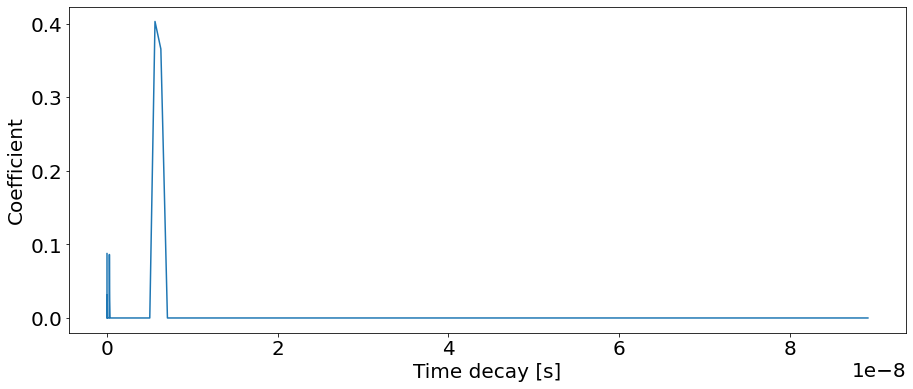

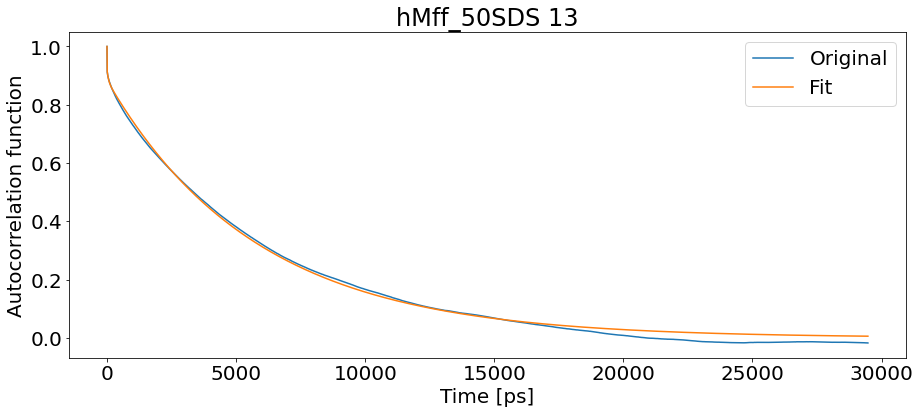

T1: 0.7720781065418671 T2: 0.10250587228153203 NOE: 0.8077932452140121


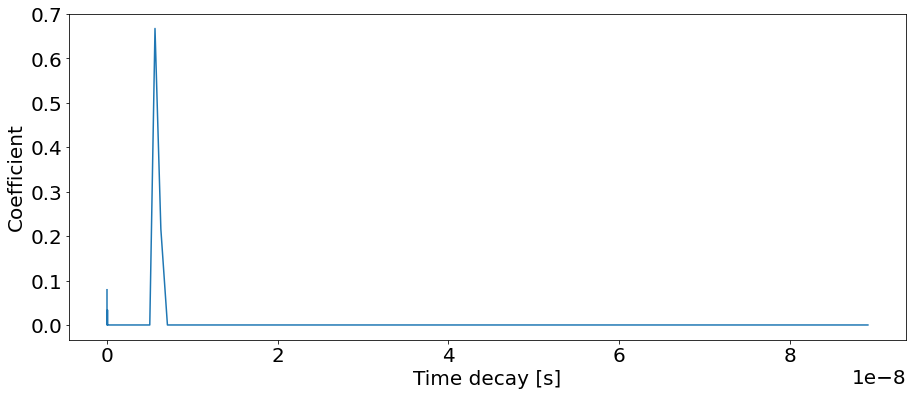

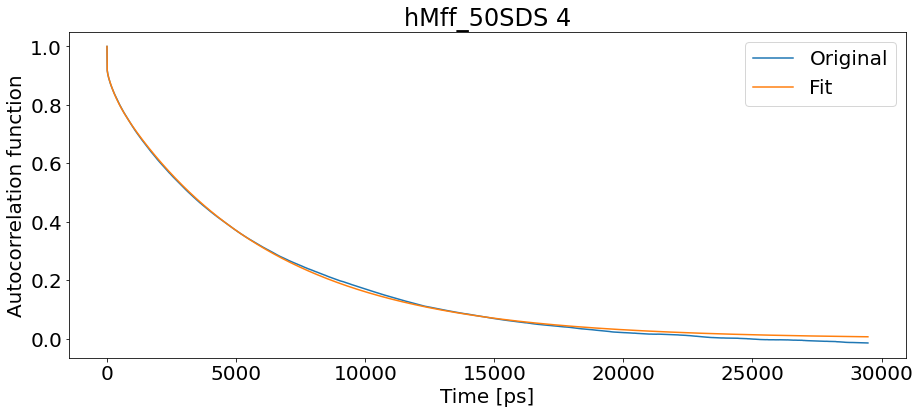

T1: 0.782721780081137 T2: 0.10229270842825823 NOE: 0.7247566919414359


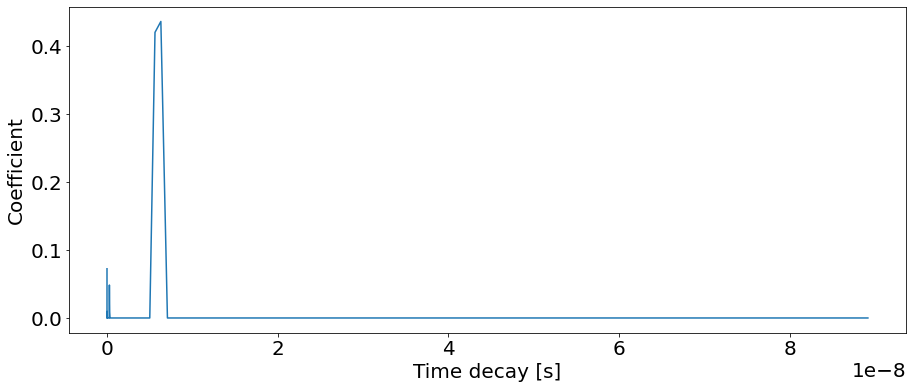

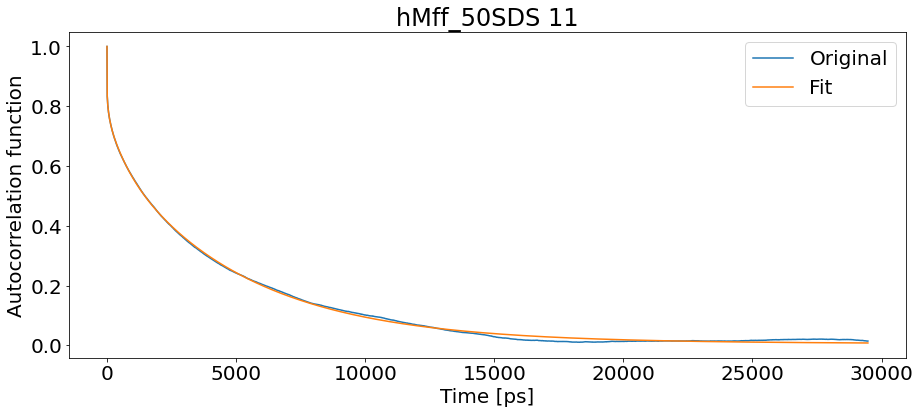

T1: 0.7716626920721524 T2: 0.12727003717133636 NOE: 0.6178759326296116


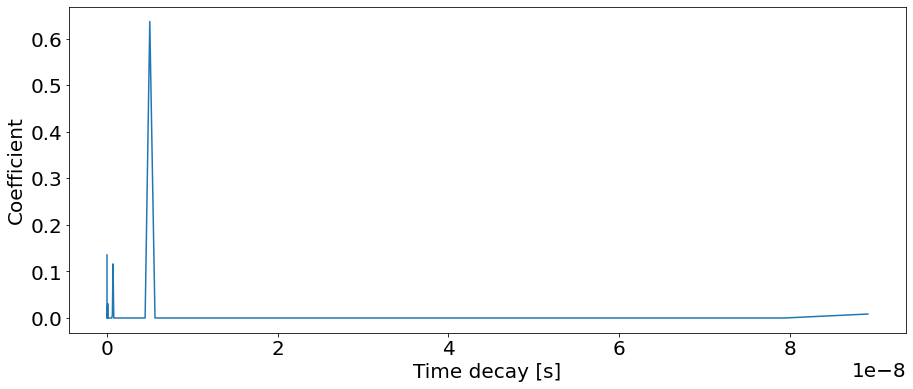

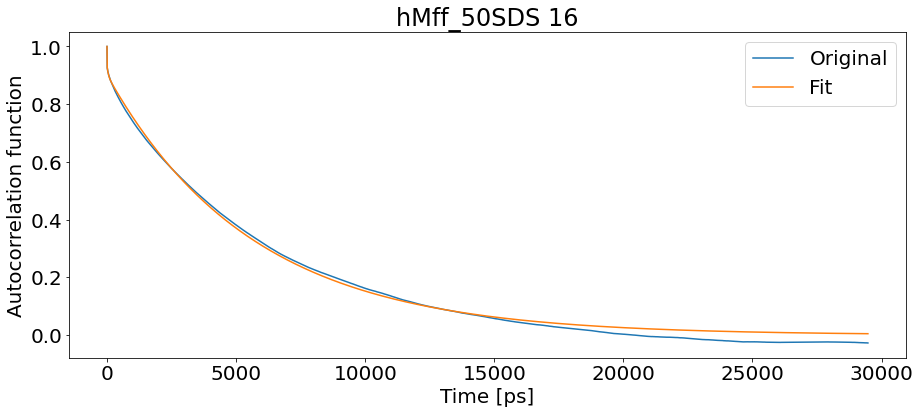

T1: 0.7417579832353091 T2: 0.10311935623170143 NOE: 0.8171084452274661


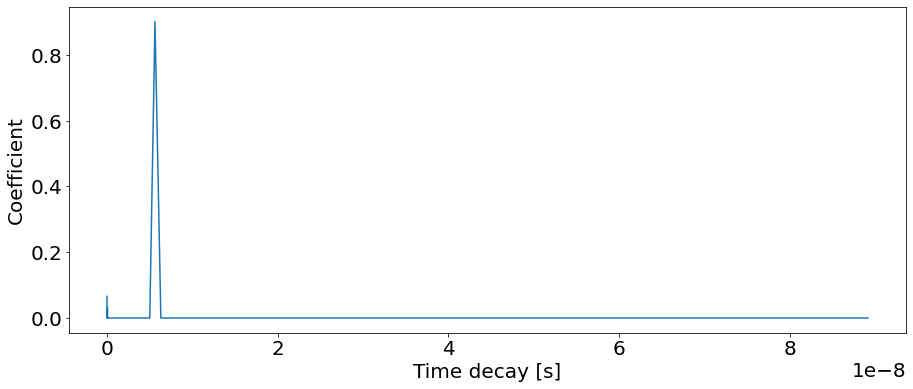

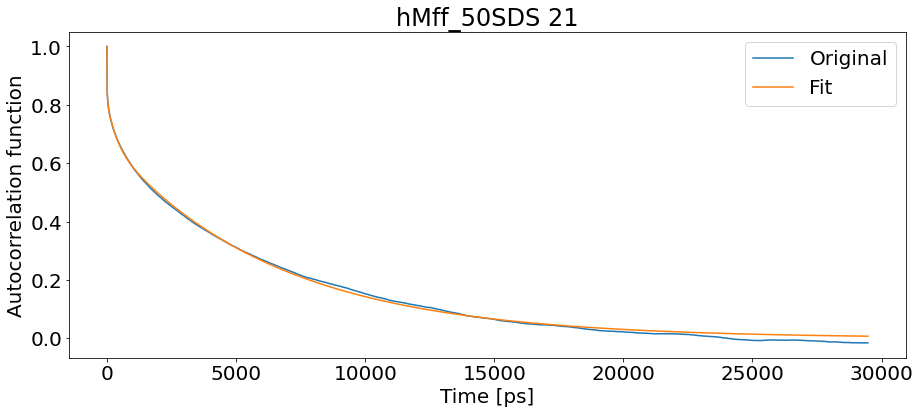

T1: 0.9288261978364863 T2: 0.11943521559873428 NOE: 0.5134875679943127


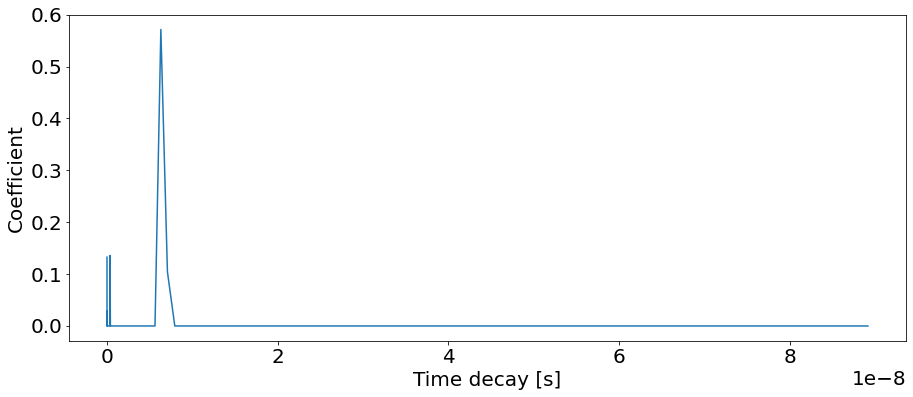

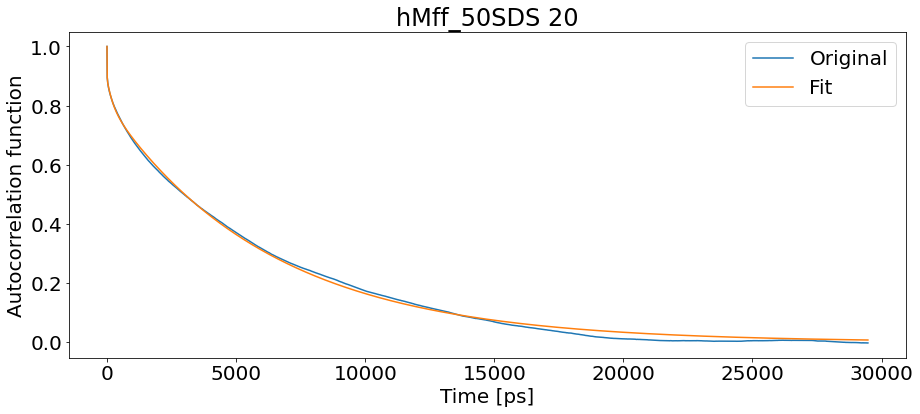

T1: 0.8509996685836496 T2: 0.10357335867015435 NOE: 0.64725860994488


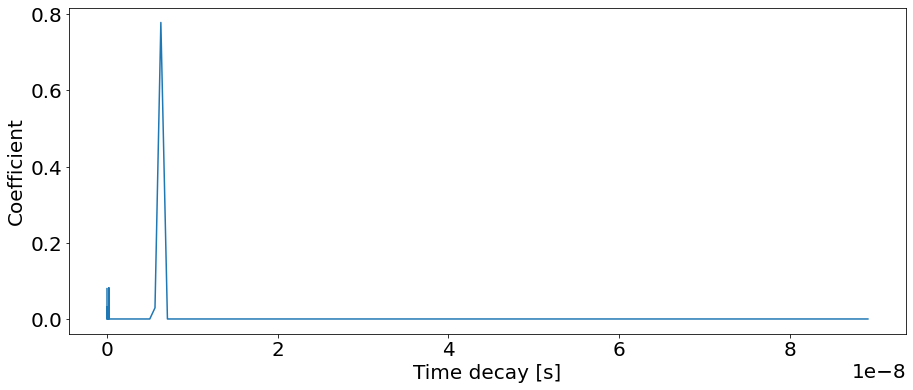

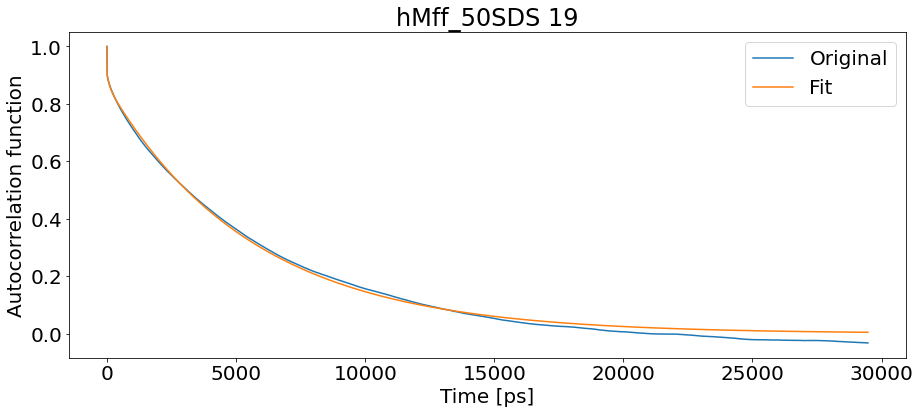

T1: 0.7652314332542208 T2: 0.10742256514322479 NOE: 0.7769299095313014


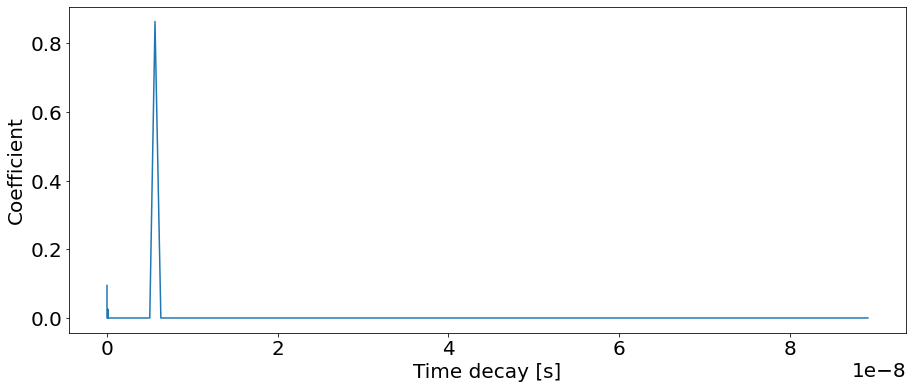

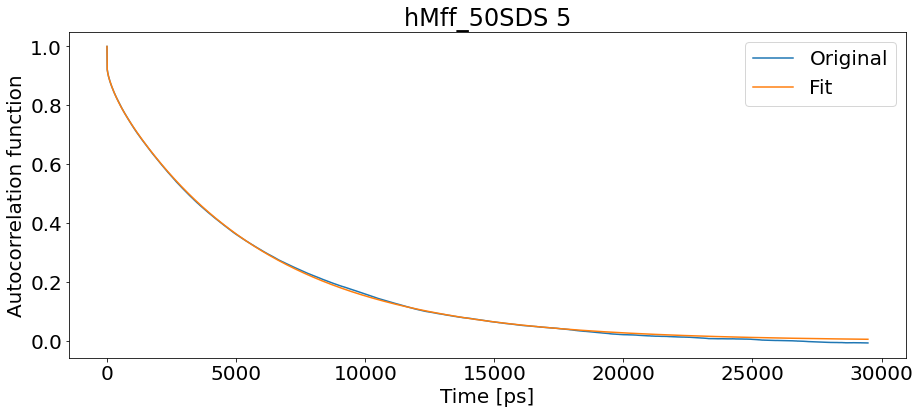

T1: 0.7588374520053075 T2: 0.1045306254409393 NOE: 0.7403820911170296


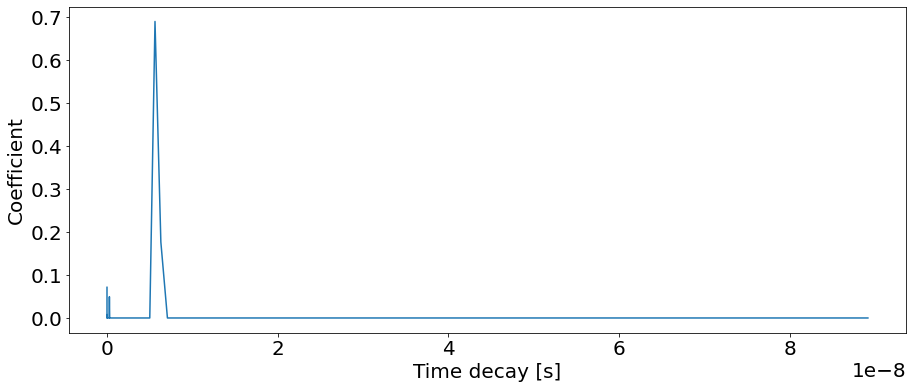

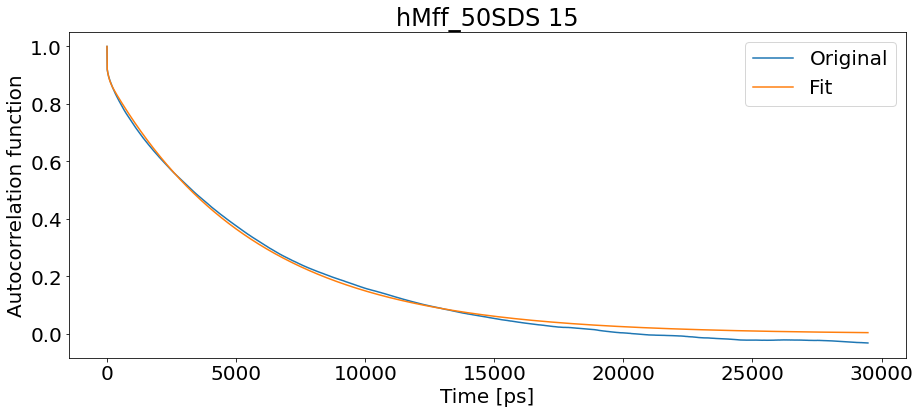

T1: 0.7472249546486772 T2: 0.10450796248414725 NOE: 0.8015861599353408


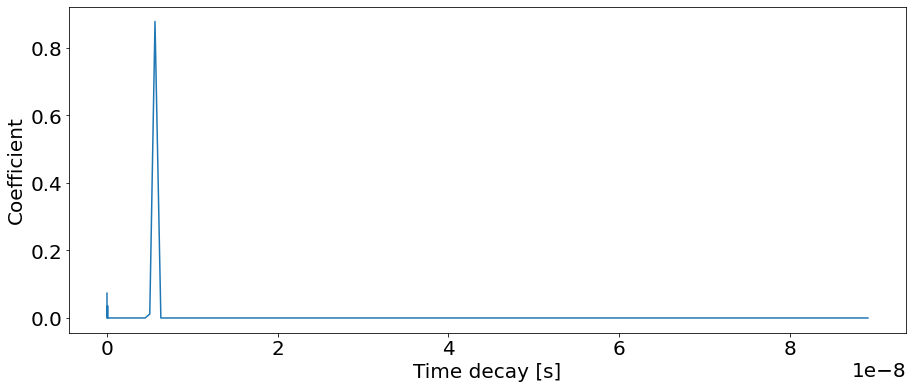

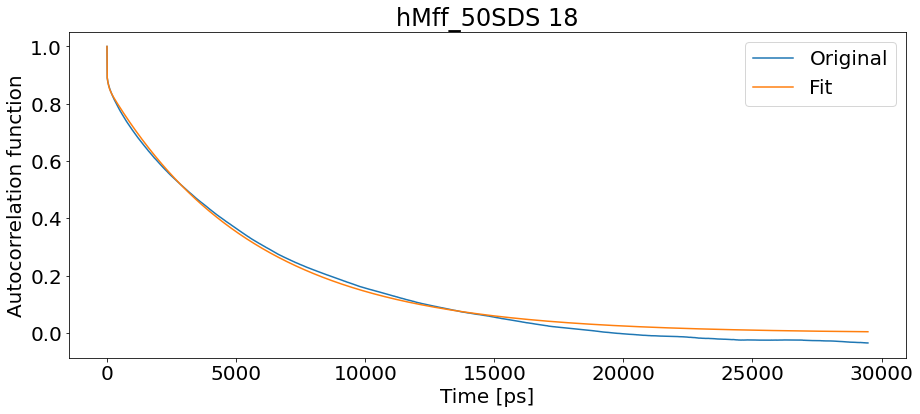

T1: 0.7746979707020539 T2: 0.10799200172893192 NOE: 0.8049261736585329


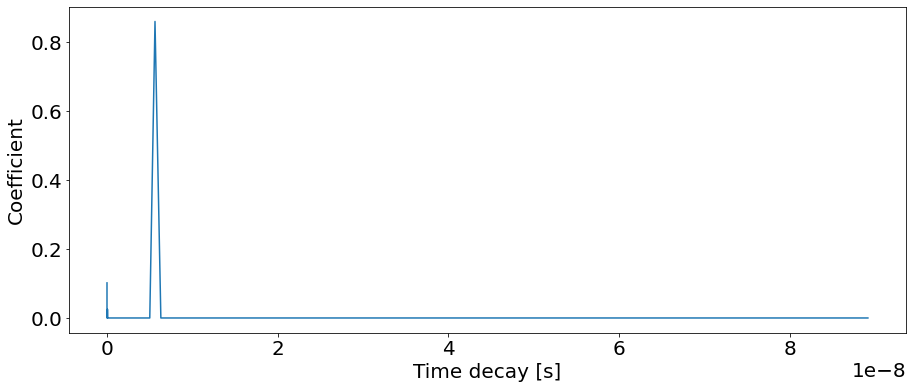

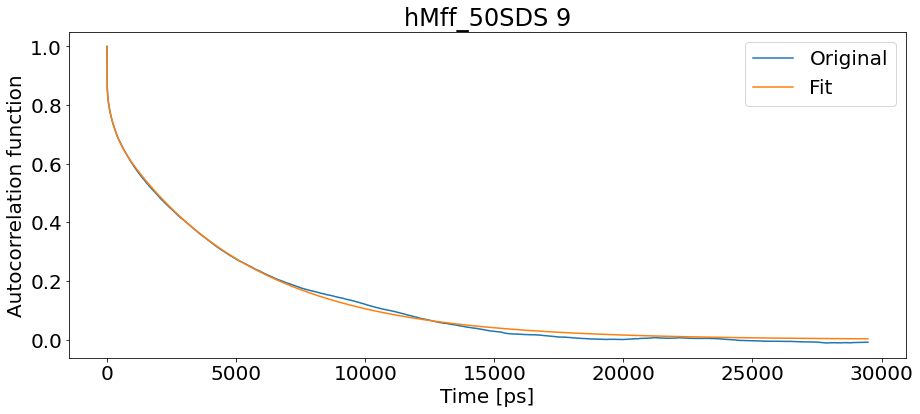

T1: 0.7868801004336633 T2: 0.13535095587669374 NOE: 0.5839998253501092


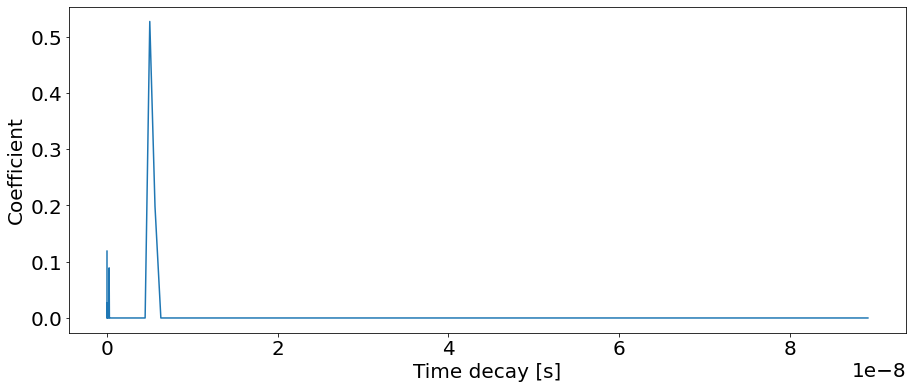

In [4]:
"""Analyze the whole content of a folder"""
aminoAcids=rt.analyze_all_in_folder(OP,smallest_corr_time, biggest_corr_time, N_exp_to_fit,analyze,magnetic_field,folder_path,nuclei,output_name)

<h3>4) Plot results</h3>

<h4>4.1) Plot T1, T2, hetNOE relaxation data</h4>

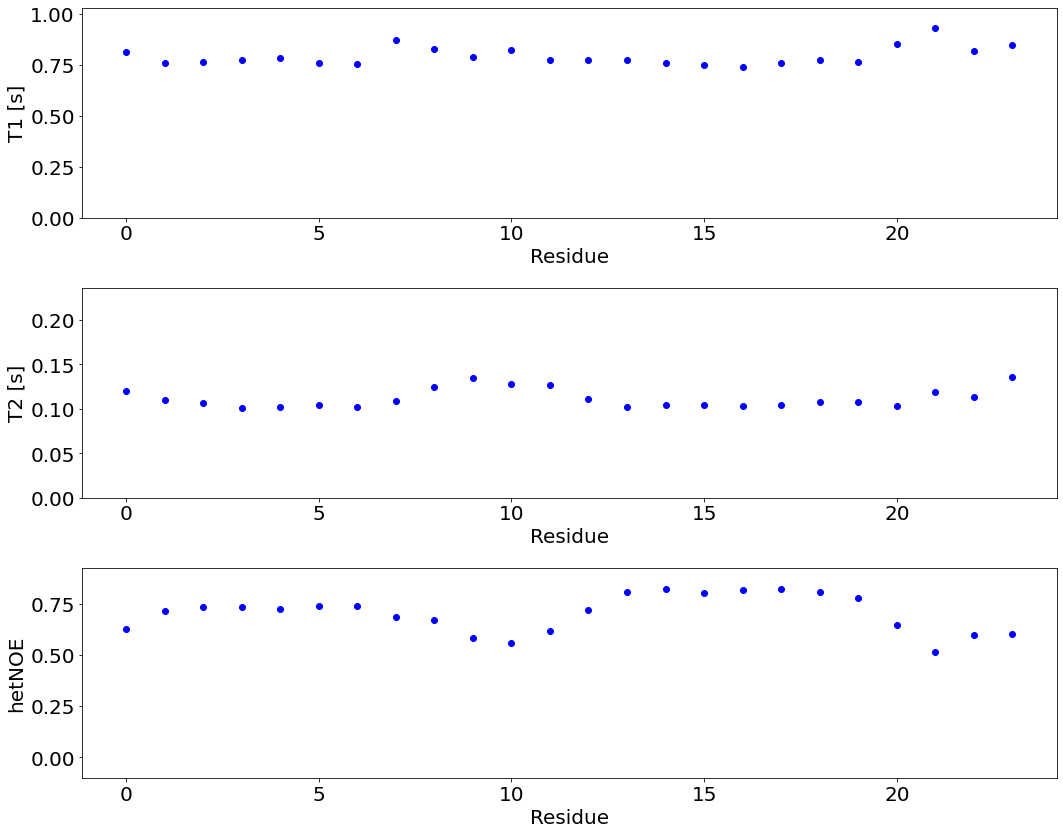

In [5]:
rt.plot_T1_T2_noe(aminoAcids)

<h4>4.2) Set y-axis range and categories to plot in different colors</h4>

In [6]:
merge=5 # number of consequent points to be merged (works on log scale!!)
groupTimes=[10**(-10),10**(-9),10**(-9)*5,10**(-8)] # groups points smaller than 1st value, 
                                                    #points between 1st and 2nd, 2nd and 3st....
                                                    #points bigger than the last value
ylim=[10**(-10),10**(-8)*2] # useful for observing details
#ylim=None # if None the whole range of available data is plotted
title="Time coefficients"
xlabel="Residue of hMff"

<h4>4.2) Plot dynamics</h4>

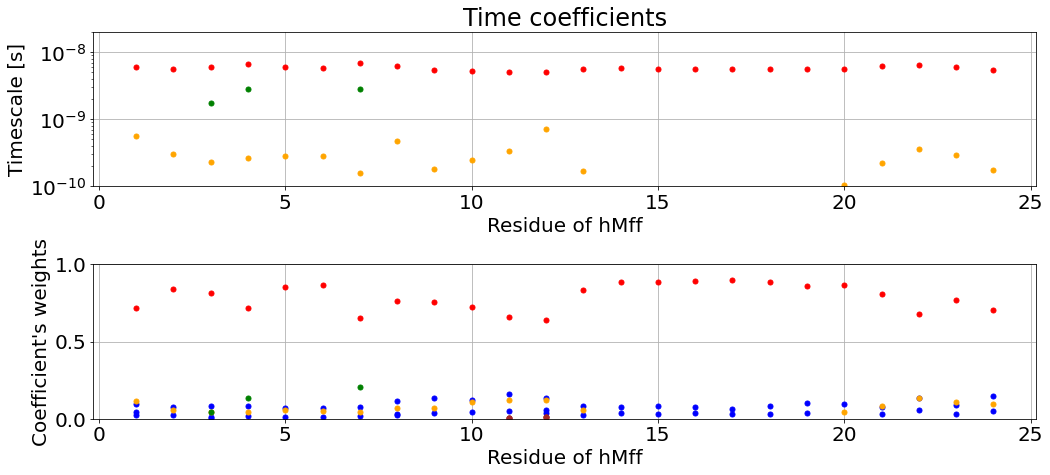

In [7]:
rt.PlotTimescales(aminoAcids,merge,groupTimes,title,xlabel,ylim)

<center><h1>Spin relaxation times as a function of field and dynamics</h1></center>

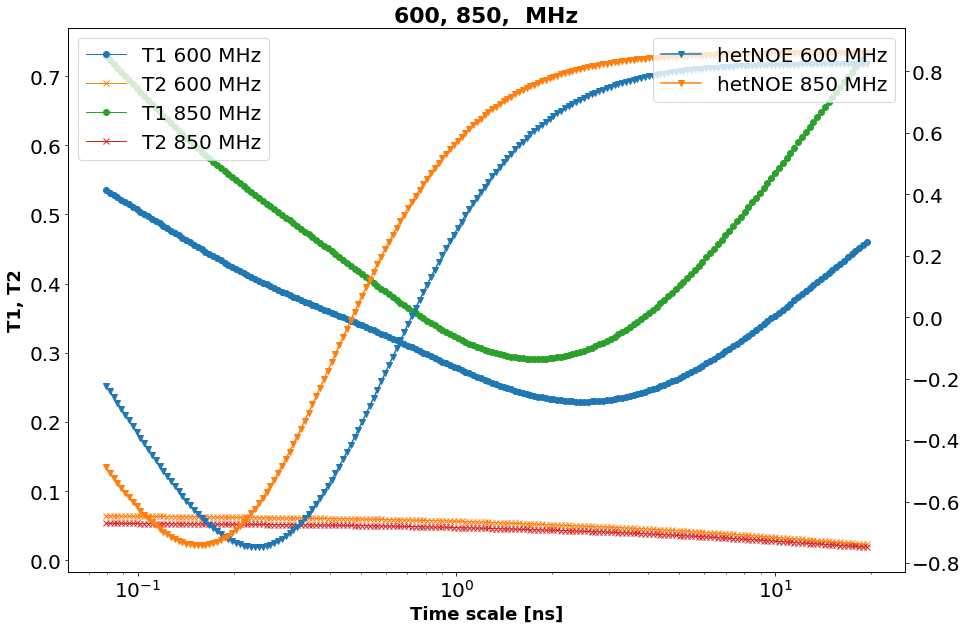

In [260]:
#plot relaxation times as a function of dynamics and magnetic field, only 2D plot, atm
magnetic_fields=[600,850]


smallest_corr_time=1.9 # enter in log scale -3 fs; 0 ps; 3 ns; 6 us;
biggest_corr_time=4.3 # same as above
N_exp_to_fit=200 # number of exponential functions to be fitted between the samlles and biggest corr time

step_exp=(biggest_corr_time-smallest_corr_time)/N_exp_to_fit
Ctimes = 10 ** np.arange(smallest_corr_time, biggest_corr_time, step_exp)
Ctimes = Ctimes * 0.001 * 10 ** (-9);

fig,ax = plt.subplots(figsize=(15, 10))
ax.set_xlabel("Time scale [ns]",fontsize=18, weight = 'bold')
ax.set_ylabel("T1, T2",fontsize=18, weight = 'bold')
ax.set_xscale('log')
ax2.set_ylabel("hetNOE",fontsize=18, weight = 'bold')
ax2.set_xscale('log')
ax2=ax.twinx()

title=""
for magn_field in magnetic_fields:
    magnetic_field=magn_field*2*np.pi/gammaH*10**6
    
    T1=[]
    T2=[]
    NOE=[]
    for time_scale in Ctimes:
        t1, t2, noe = rt.get_relaxation_N(magnetic_field,[1,1],[time_scale,10**-8],OP)
        T1.append(t1)
        T2.append(t2)
        NOE.append(noe)
        
    
    ax.plot(Ctimes*10**9,T1,label="T1 " + str(magn_field)+ " MHz",  marker="o", linewidth=1.0)
    ax.plot(Ctimes*10**9,T2,label="T2 " + str(magn_field)+ " MHz",   marker="x", linewidth=1.0)
    
    
    ax2.plot(Ctimes*10**9,NOE,label="hetNOE " + str(magn_field)+ " MHz",marker="v")
    title+= str(magn_field) + ", "
    

ax.set_title(str(title)+ " MHz",fontsize=22, weight = 'bold')
ax2.legend(loc='upper right')

ax.legend(loc='upper left')
plt.show()